In [ ]:
#%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt

This following code generates a vector field for defects that is labeled with the topological charge of each defect. This training data is for the model that only identifies whether the defect is +1/2 or -1/2, not its locaiton.

In [ ]:

def generate_defect_field(size=100, defect_type='+1/2', defect_location=(50, 50), defect_strength=0.1):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    field = np.zeros((size, size, 2))

    # Generate a +1/2 defect
    if defect_type == '+1/2':
        charge = 0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0])
        field[:, :, 0] = np.sin(theta) * defect_strength
        field[:, :, 1] = -np.cos(theta) * defect_strength

    # Generate a -1/2 defect
    elif defect_type == '-1/2':
        charge = -0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0])
        field[:, :, 0] = -np.sin(theta) * defect_strength
        field[:, :, 1] = np.cos(theta) * defect_strength
    norm = np.sqrt(field[:,:,0]**2 + field[:,:,1]**2)
    field[:,:,0] = field[:,:,0]/norm
    field[:,:,1] = field[:,:,1]/norm
    return field

def plot_defect_field(field):
    size = field.shape[0]
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.75
    )
    plt.show()

def generate_labeled_dataset(num_samples=100, size=100, defect_strength=0.1):
    X = []
    y = []

    for _ in range(num_samples):
        # Randomly choose a defect type and location
        defect_type = np.random.choice(['+1/2', '-1/2'])
        defect_location = (np.random.randint(size), np.random.randint(size))
        # Generate the defect field
        defect_field = generate_defect_field(size=size, defect_type=defect_type, defect_location=defect_location, defect_strength=defect_strength)

        # Append to the dataset
        X.append(defect_field.flatten())
        y.append(1 if defect_type == '+1/2' else 0)

    return np.array(X), np.array(y)

# Example usage:
num_samples = 100
size = 100
defect_strength = 1#0.1

X, y = generate_labeled_dataset(num_samples=num_samples, size=size, defect_strength=defect_strength)

# Print labels to check the distribution of +1/2 and -1/2 defects
print("Label distribution:", np.unique(y, return_counts=True))

# Visualize a few examples
for i in range(5):
    plot_defect_field(X[i].reshape((size, size, 2)))

The `DefectClassifier` model is a neural network designed for binary classification, specifically for predicting the type of a defect in a liquid crystal director field. The input to the model is a vectorized representation of the defect field, and it consists of a single branch that outputs a probability score using a sigmoid activation function. The model is trained using binary cross-entropy loss (`BCELoss`) to optimize the binary classification task. The training process includes early stopping based on the validation loss to prevent overfitting. This model is suitable for scenarios where the primary interest is in classifying defects into different types, providing valuable information about the nature of defects in the vector field.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming you have X and y from the generate_labeled_dataset function

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a simple neural network model
class DefectClassifier(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
model = DefectClassifier(input_size=X_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up early stopping
best_model_state_dict = None
best_validation_loss = float('inf')
patience = 10 # Adjust this based on your scenario
counter = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.16f}')

    # Calculate validation loss
    with torch.no_grad():
        model.eval()
        validation_outputs = model(X_validation)
        validation_loss = criterion(validation_outputs, y_validation.view(-1, 1))

    print(f'Validation Loss: {validation_loss.item():.16f} best_validation_loss: {best_validation_loss:.16f}')
    print(validation_loss.item(),best_validation_loss,np.abs(validation_loss-best_validation_loss))
    # Check for early stopping
    if validation_loss.item() <= best_validation_loss:
    #if np.isclose(np.abs(validation_loss-best_validation_loss),0.0,rtol=1e-15):
    #if np.isclose(validation_loss.item(), best_validation_loss, rtol=1e-15):
        best_validation_loss = validation_loss
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break
    print(counter)

# Load the best model
model.load_state_dict(best_model_state_dict)

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    y_pred = (model(X_test) > 0.5).float()
    print(classification_report(y_test.numpy(), y_pred.numpy()))


In [ ]:
# Assuming you have a single test field as a NumPy array called 'single_test_field'
defect_type = np.random.choice(['+1/2', '-1/2'])
single_test_field = generate_defect_field(size=100, 
                                        defect_type=defect_type,
                                        defect_location=(np.random.randint(100), np.random.randint(100)),
                                        defect_strength=1.0)
print(defect_type)
single_test_field_tensor = torch.tensor(single_test_field.flatten(), dtype=torch.float32)

# Make a prediction
with torch.no_grad():
    model.eval()
    prediction = model(single_test_field_tensor)

# Convert the prediction to a human-readable label
label = "Defect +1/2" if prediction.item() > 0.5 else "Defect -1/2"

print("Prediction:", label)

This is the generation code for identifying the location and topological charge of defects.

In [ ]:

def generate_defect_field(size=100, defect_type='+1/2', defect_location=(50, 50), defect_strength=0.1):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    field = np.zeros((size, size, 2))

    # Generate a +1/2 defect
    if defect_type == '+1/2':
        charge = 0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0])
        field[:, :, 0] = np.sin(theta) * defect_strength
        field[:, :, 1] = -np.cos(theta) * defect_strength

    # Generate a -1/2 defect
    elif defect_type == '-1/2':
        charge = -0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0])
        field[:, :, 0] = -np.sin(theta) * defect_strength
        field[:, :, 1] = np.cos(theta) * defect_strength
    norm = np.sqrt(field[:,:,0]**2 + field[:,:,1]**2)
    field[:,:,0] = field[:,:,0]/norm
    field[:,:,1] = field[:,:,1]/norm
    return field

def plot_defect_field(field):
    size = field.shape[0]
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.75
    )
    plt.show()

def generate_labeled_dataset(num_samples=100, size=100, defect_strength=0.1):
    X = []
    y_type = []
    y_loc = []

    for _ in range(num_samples):
        # Randomly choose a defect type and location
        defect_type = np.random.choice(['+1/2', '-1/2'])
        defect_location = (np.random.randint(size), np.random.randint(size))
        # Generate the defect field
        defect_field = generate_defect_field(size=size, defect_type=defect_type, defect_location=defect_location, defect_strength=defect_strength)

        # Append to the dataset
        X.append(defect_field.flatten())
        y_type.append(1 if defect_type == '+1/2' else 0)
        y_loc.append(defect_location)
    
    return np.array(X), np.array(y_type), np.array(y_loc)

# Example usage:
num_samples = 1000
size = 100
defect_strength = 1#0.1

X, y_type, y_loc = generate_labeled_dataset(num_samples=num_samples, size=size, defect_strength=defect_strength)
print(X.shape)
# Print labels to check the distribution of +1/2 and -1/2 defects
print("Label distribution:", np.unique(y_type, return_counts=True))

# Visualize a few examples
for i in range(5):
    plot_defect_field(X[i].reshape((size, size, 2)))

The `DefectClassifierMultiTask` model is a neural network designed for multi-task learning, capable of predicting both the type and location of a defect in a liquid crystal director field. The input to the model is a vectorized representation of the defect field, and it consists of two main branches. The first branch focuses on defect type prediction using a sigmoid activation function for binary classification. The second branch is responsible for defect location prediction and outputs a pair of values representing the (x, y) coordinates of the defect. The model is trained using two loss functions: binary cross-entropy loss (`BCELoss`) for defect type prediction and mean squared error loss (`MSELoss`) for defect location prediction. The training process includes early stopping based on the validation loss to prevent overfitting. This multi-task model provides a comprehensive solution for defect analysis in structured vector fields, offering insights into both the nature and spatial distribution of defects.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

# Assuming you have X and y from the generate_labeled_dataset function

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_type_tensor = torch.tensor(y_type, dtype=torch.float32)
y_loc_tensor = torch.tensor(y_loc, dtype=torch.float32)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_type_train, y_type_temp, y_loc_train, y_loc_temp = train_test_split(X_tensor, y_type_tensor, y_loc_tensor, test_size=0.3, random_state=42)
X_validation, X_test, y_type_validation, y_type_test, y_loc_validation, y_loc_test = train_test_split(X_temp, y_type_temp, y_loc_temp, test_size=0.5, random_state=42)

print(y_train.shape)
# Define a multi-task neural network model
class DefectClassifierMultiTask(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifierMultiTask, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        
        # Branch for defect type prediction
        self.fc2_type = nn.Linear(128, 1)
        self.sigmoid_type = nn.Sigmoid()
        
        # Branch for defect location prediction
        self.fc2_location = nn.Linear(128, 2)  # Assuming (x, y) coordinates
        self.tanh_location = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        # Defect type prediction
        output_type = self.sigmoid_type(self.fc2_type(x))
        
        # Defect location prediction
        output_location = self.tanh_location(self.fc2_location(x))
        
        return output_type, output_location

# Initialize the model, loss functions, and optimizer
print(X_tensor.shape)
model = DefectClassifierMultiTask(input_size=X_tensor.shape[1])
criterion_type = nn.BCELoss()
criterion_location = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up early stopping
best_model_state_dict = None
best_validation_loss = float('inf')
patience = 5  # Adjust this based on your scenario
counter = 0

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs_type, outputs_location = model(X_train)
    
    # Loss for defect type prediction
    loss_type = criterion_type(outputs_type, y_type_train.view(-1, 1))
    
    # Loss for defect location prediction
    loss_location = criterion_location(outputs_location, y_loc_train.view(-1, 2))  # Assuming (x, y) coordinates
    
    # Total loss (sum of type and location losses)
    loss = loss_type + loss_location

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Type: {loss_type.item():.4f}, Loss Location: {loss_location.item():.4f}')

 # Calculate validation loss
    with torch.no_grad():
        model.eval()
        outputs_type_val, outputs_location_val = model(X_validation)
        
        # Validation loss for defect type prediction
        validation_loss_type = criterion_type(outputs_type_val, y_type_validation.view(-1, 1))
        
        # Validation loss for defect location prediction
        validation_loss_location = criterion_location(outputs_location_val, y_loc_validation.view(-1, 2))
        
        # Total validation loss (sum of type and location losses)
        validation_loss = validation_loss_type + validation_loss_location

    print(f'Validation Loss Type: {validation_loss_type.item():.4f}, Validation Loss Location: {validation_loss_location.item():.4f}')

    # Check for early stopping
    if validation_loss <= best_validation_loss:
        best_validation_loss = validation_loss
        best_model_state_dict = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch + 1} epochs.')
            break


# Load the best model
model.load_state_dict(best_model_state_dict)

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    outputs_type_test, outputs_location_test = model(X_test)

    # Assuming outputs_location_test is the predicted locations
    outputs_location_scale = (outputs_location_test + 1) * 50.0  # Assuming the range is 0 to 100
    print(outputs_location_scale)
    
    # Convert outputs_type_test to binary predictions
    predictions_type_test = (outputs_type_test > 0.5).float()
    #predictions_loc_test = (outputs_location_test > 0.5).float()
    
    # Calculate MSE for defect location prediction
    mse_location = mean_squared_error(outputs_location_scale.numpy(), y_loc_test.numpy())
    
    # Evaluate defect type prediction
    print("Defect Type Prediction:")
    print(classification_report(y_type_test.numpy(), predictions_type_test.numpy()))

    # Evaluate defect location prediction
    #print(classification_report(y_loc_test.numpy(), predictions_loc_test.numpy()))
    print("Defect Location Prediction (MSE):", mse_location)


In [ ]:
# Assuming you have a single test field as a NumPy array called 'single_test_field'
defect_type = np.random.choice(['+1/2', '-1/2'])
defect_loc = (np.random.randint(100), np.random.randint(100))
single_test_field = generate_defect_field(size=100, 
                                        defect_type=defect_type,
                                        defect_location=defect_loc,
                                        defect_strength=1.0)
print(defect_type)
print(defect_loc)
single_test_field_tensor = torch.tensor(single_test_field.flatten(), dtype=torch.float32)

# Make a prediction
with torch.no_grad():
    model.eval()
    prediction = model(single_test_field_tensor)
print(prediction[0])
# Convert the prediction to a human-readable label
label = "Defect +1/2" if prediction[0].item() > 0.5 else "Defect -1/2"
print("Type Prediction:", label)
print("Location Prediction:",prediction[1])

So instead of training the model on an entire defect field and looking at the location, we should train the model on a smaller field that can be a subset of the larger director field. This smaller field would have a defect always in the center, but  Then iterate over (x,y) in a larger director field and input each point and its surrounding neighbors into the model to test and see if there is a defect!


---------
Yes, that's a reasonable approach. If the structure of your defect field allows for the identification of defects using as little as a 3 by 3 neighborhood, you can train a model to predict the presence or absence of a defect in such local regions. This can be an efficient way to identify potential defect locations in a larger grid.

Here's a simplified outline of the process:

1. Data Preparation:
Generate your training dataset by extracting 3 by 3 local neighborhoods from your defect field.
Label each sample based on the presence or absence of a defect in the center point of the 3 by 3 region.
2. Model Architecture:
Design a neural network model suitable for binary classification (presence or absence of a defect).
The input layer should have the appropriate size for a 3 by 3 neighborhood.
3. Training:
Train the model on your dataset with binary labels indicating the presence or absence of a defect.
4. Testing:
After training, iterate through each point in your larger grid, extract the local 3 by 3 neighborhood, and use the trained model to predict whether there is a defect at the center point.
This approach allows you to leverage the local structure of the defect field to make predictions efficiently. It also reduces the computational cost compared to making predictions for each point independently.

Remember to carefully choose the appropriate architecture, hyperparameters, and normalization techniques based on your specific dataset and task. Additionally, ensure that your training dataset is representative of the actual distribution of defects in your larger grid.

Label distribution: (array([0, 1]), array([42, 58]))


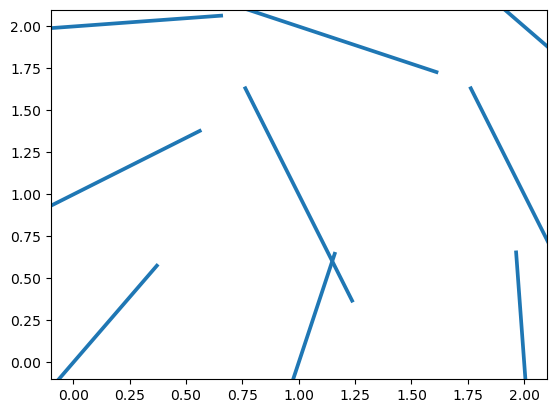

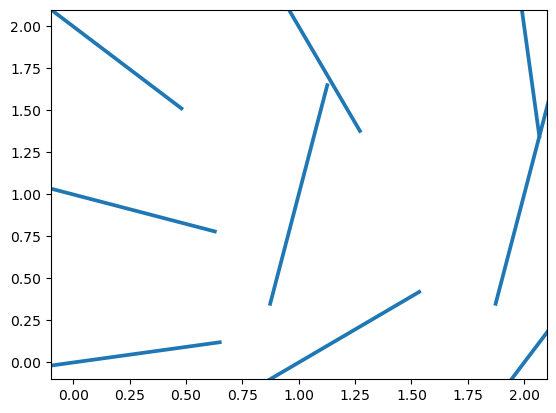

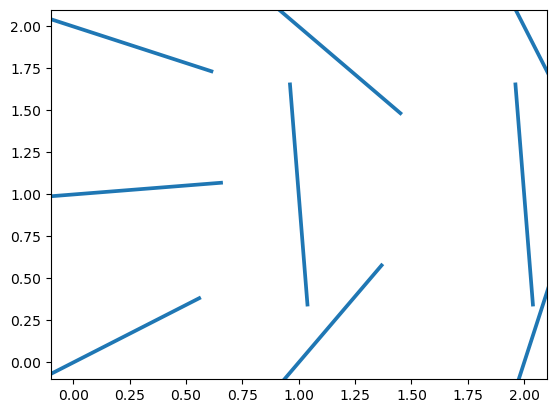

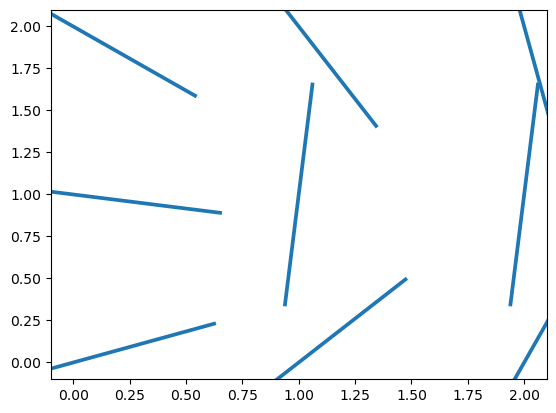

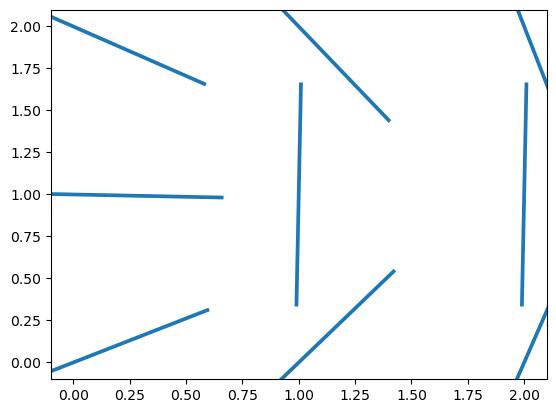

In [106]:

def generate_defect_field(size=100, defect_type='+1/2', defect_location=(1, 1), defect_strength=0.1):
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    field = np.zeros((size, size, 2))
    rotation = np.random.uniform(0,np.pi*2)
    # Generate a +1/2 defect
    if defect_type == '+1/2':
        charge = 0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0]) + rotation
        field[:, :, 0] = np.sin(theta) * defect_strength
        field[:, :, 1] = -np.cos(theta) * defect_strength

    # Generate a -1/2 defect
    elif defect_type == '-1/2':
        charge = -0.5
        r = np.sqrt((x - defect_location[0]) ** 2 + (y - defect_location[1]) ** 2)
        theta = charge*np.arctan2(y - defect_location[1], x - defect_location[0]) + rotation
        field[:, :, 0] = -np.sin(theta) * defect_strength
        field[:, :, 1] = np.cos(theta) * defect_strength
    norm = np.sqrt(field[:,:,0]**2 + field[:,:,1]**2)
    field[:,:,0] = field[:,:,0]/norm
    field[:,:,1] = field[:,:,1]/norm
    return field

def plot_defect_field(field):
    size = field.shape[0]
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    plt.quiver(x,y,field[:, :, 0], field[:, :, 1],
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.75
    )
    plt.show()

def generate_labeled_dataset(num_samples=100, size=100, defect_strength=0.1):
    X = []
    y = []

    for _ in range(num_samples):
        # Randomly choose a defect type and location
        defect_type = np.random.choice(['+1/2', '-1/2'])
        defect_location = (1,1)#(np.random.randint(size), np.random.randint(size))
        # Generate the defect field
        defect_field = generate_defect_field(size=size, defect_type=defect_type, defect_location=defect_location, defect_strength=defect_strength)

        # Append to the dataset
        X.append(defect_field.flatten())
        y.append(1 if defect_type == '+1/2' else 0)

    return np.array(X), np.array(y)

# Example usage:
num_samples = 100
size = 3
defect_strength = 1#0.1

X, y = generate_labeled_dataset(num_samples=num_samples, size=size, defect_strength=defect_strength)

# Print labels to check the distribution of +1/2 and -1/2 defects
print("Label distribution:", np.unique(y, return_counts=True))

# Visualize a few examples
# test_field = generate_defect_field(size,"+1/2",(1,1),1)
# plot_defect_field(test_field)
for i in range(5):
    plot_defect_field(X[i].reshape((size, size, 2)))

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are your training data and labels
# X_train should be a tensor of shape (num_samples, 9) representing 3x3 neighborhoods
# y_train should be a tensor of shape (num_samples,) with binary labels (0 or 1)

class DefectClassifier3x3(nn.Module):
    def __init__(self, input_size):
        super(DefectClassifier3x3, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Example usage:
# Assuming X_train and y_train are your training data and labels
# X_train should be a tensor of shape (num_samples, 9) representing 3x3 neighborhoods
# y_train should be a tensor of shape (num_samples,) with binary labels (0 or 1)

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
print(X_tensor.shape)
y_tensor = torch.tensor(y, dtype=torch.float32)
print(y_tensor.shape)

# Split the data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Initialize the model, loss function, and optimizer
model = DefectClassifier3x3(input_size=9)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    
    # Compute the loss
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for monitoring
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validation
with torch.no_grad():
    model.eval()
    outputs_validation = model(X_validation)
    predictions_validation = (outputs_validation > 0.5).float()
    accuracy = (predictions_validation == y_validation.view(-1, 1)).float().mean().item()

print(f'Validation Accuracy: {accuracy:.4f}')


torch.Size([100, 18])
torch.Size([100])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x18 and 9x128)